In [7]:
#Delete WebHook
url_webhook = f'https://api.telegram.org/bot{token}/deleteWebhook'

response = requests.get(url_webhook)
if response.status_code == 200:
    print('Webhook excluído com sucesso.')
else:
    print('Erro ao excluir webhook:', response.text)


Webhook excluído com sucesso.


In [19]:
get_updates_url = f'{url}/getUpdates'
response = requests.get(get_updates_url)
updates = response.json()

print(json.dumps(updates, indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 602574974,
      "message": {
        "message_id": 12,
        "from": {
          "id": 6877828194,
          "is_bot": false,
          "first_name": "Beatriz",
          "last_name": "Mendon\u00e7a",
          "language_code": "en"
        },
        "chat": {
          "id": -1002210793670,
          "title": "eu",
          "type": "supergroup"
        },
        "date": 1724532498,
        "text": "Oi. Testando ap\u00f3s usar o WebHook"
      }
    }
  ]
}


## **Data ingestion**

###**AWS S3**

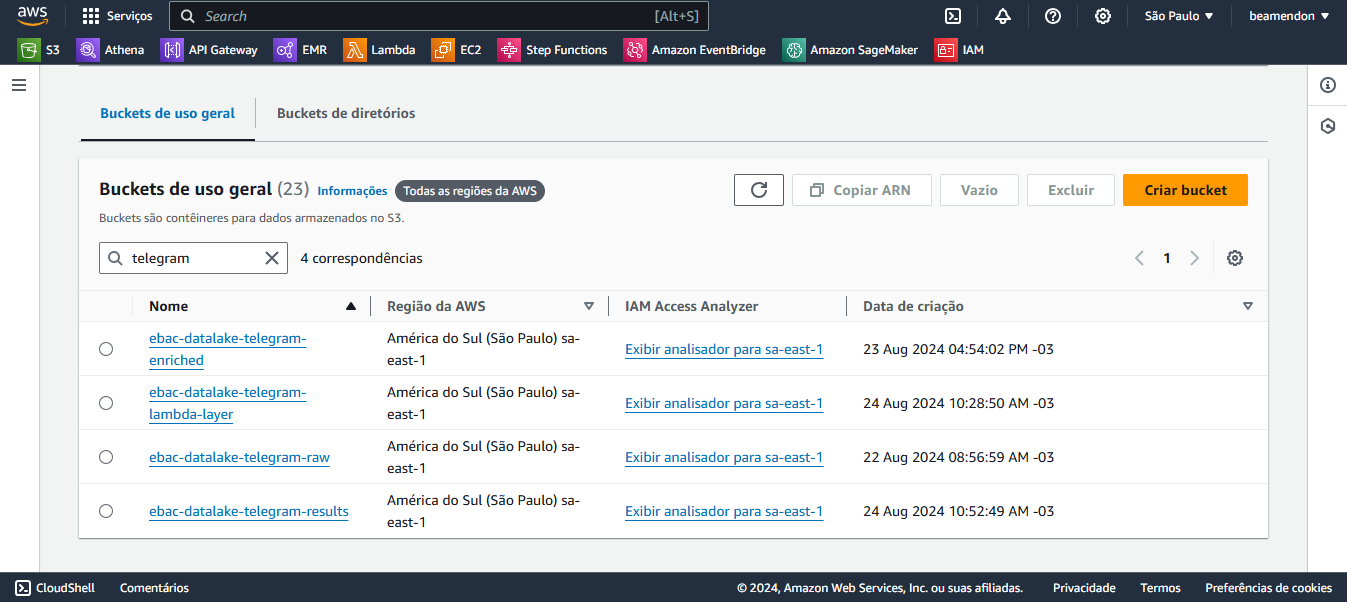

###**AWS Lambda function**

Used to receiving messages and storing them in JSON format in the raw data bucket. Environment variables were configured and permissions for interacting with AWS S3 were added in AWS IAM.

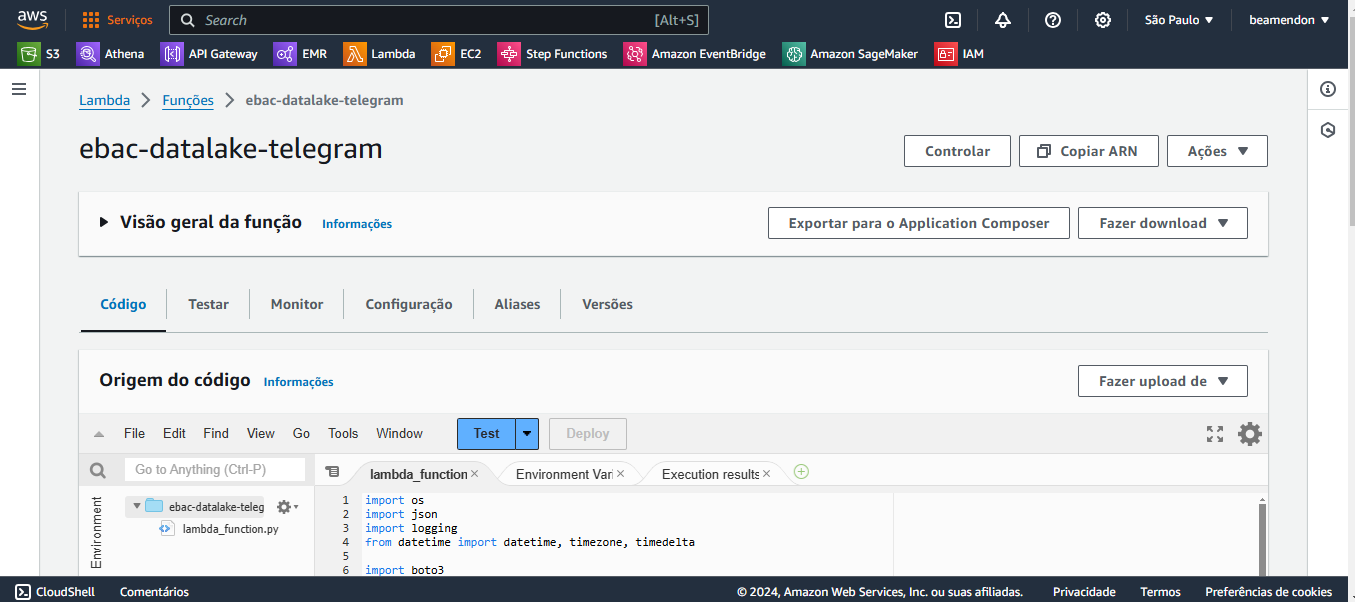

**Code**

Receives a message from Telegram via AWS API Gateway, checks its content to see if it was produced in a specific group, and writes it, in its original JSON format, to an AWS S3 bucket.


In [22]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.2 MB/s eta 0:00:00


In [23]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta
import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  # enviroment variables

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # logical variables

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # main code

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    #message = event
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

###**API development with AWS API Gateway**

The AWS API Gateway serves to receive messages captured by the Telegram bot, sent via webhook, and trigger an AWS Lambda function, passing the message content in its event parameter.

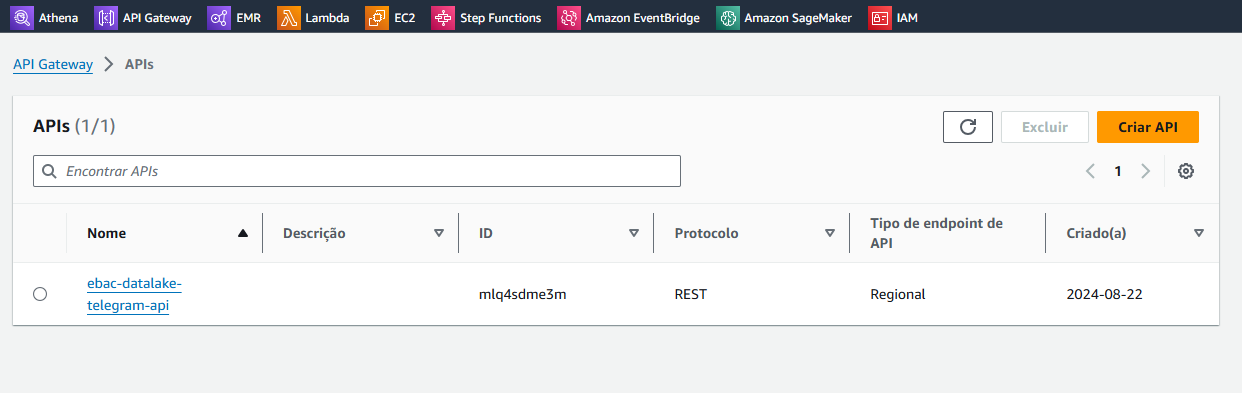

**Webhook configuration**

In [25]:
aws_api_gateway_url = getpass()

··········


In [26]:
response = requests.get(url=f'{url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


In [28]:
response = requests.get(url=f'{url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://mlq4sdme3m.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "18.230.90.200"
  }
}


##**ETL**

###**AWS Lambda function**

AWS Lambda contains the function below responsible for processing the messages captured by the Telegram bot, stored in the raw layer in the AWS S3 bucket, and persisting them in the enriched layer, also in an AWS S3 bucket.

In this step, the file is downloaded, the message content is loaded, data wrangling is performed, and a PyArrow table is created with the collected information.

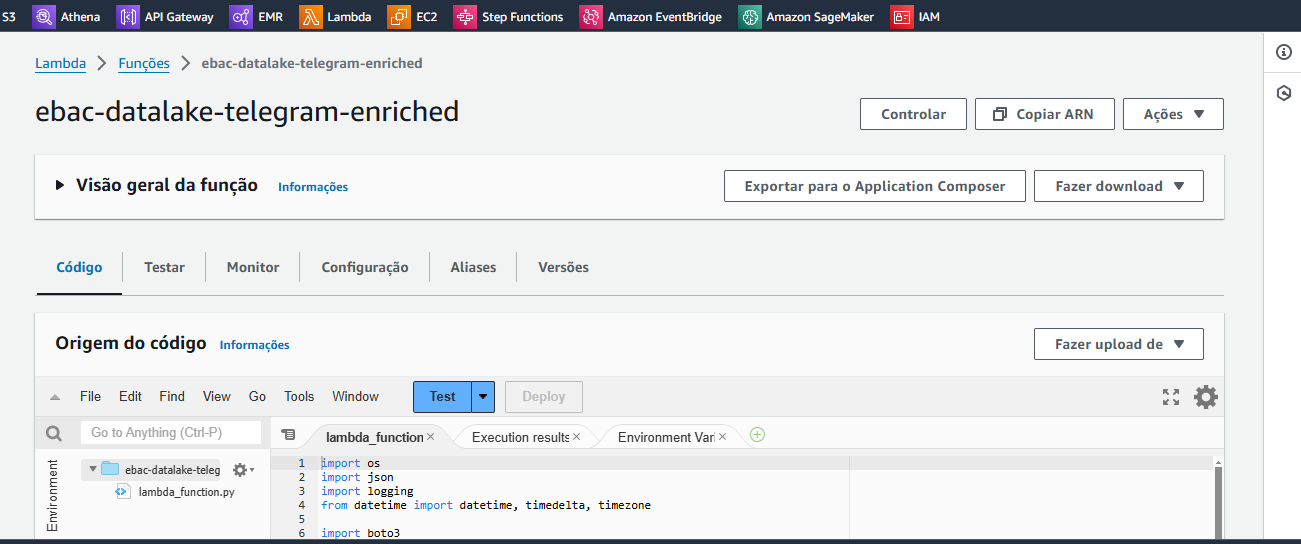

Daily, it is executed to compress the various messages in JSON format from the previous day, stored in the raw data bucket, into a single PARQUET file, and store it in the enriched data bucket.

In [29]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  #Enviroment variables

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  #Logical variables

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  #main code

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

Data wrangling:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

**Note:** was created layers in Lambda to use PyArrow.

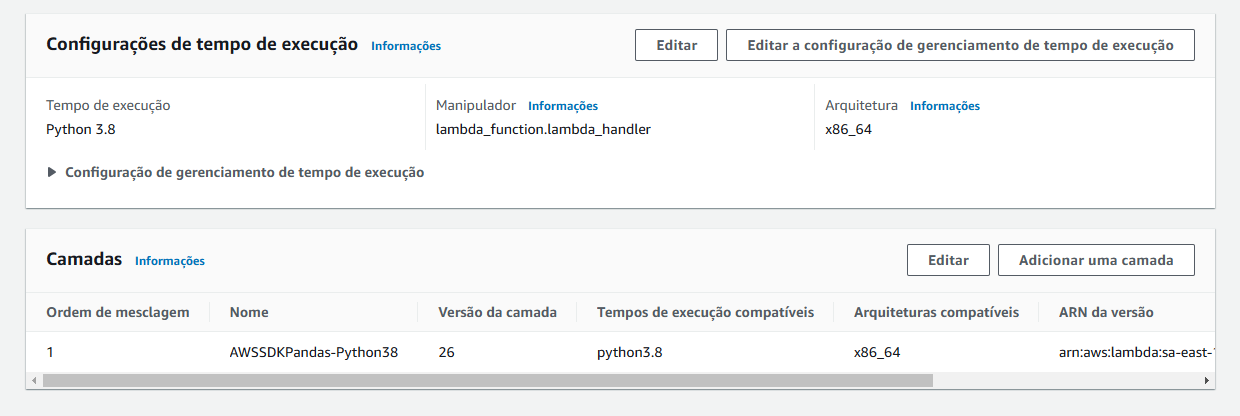

###**AWS Event Bridge**

Rule in AWS EventBridge to execute the AWS Lambda function every day.

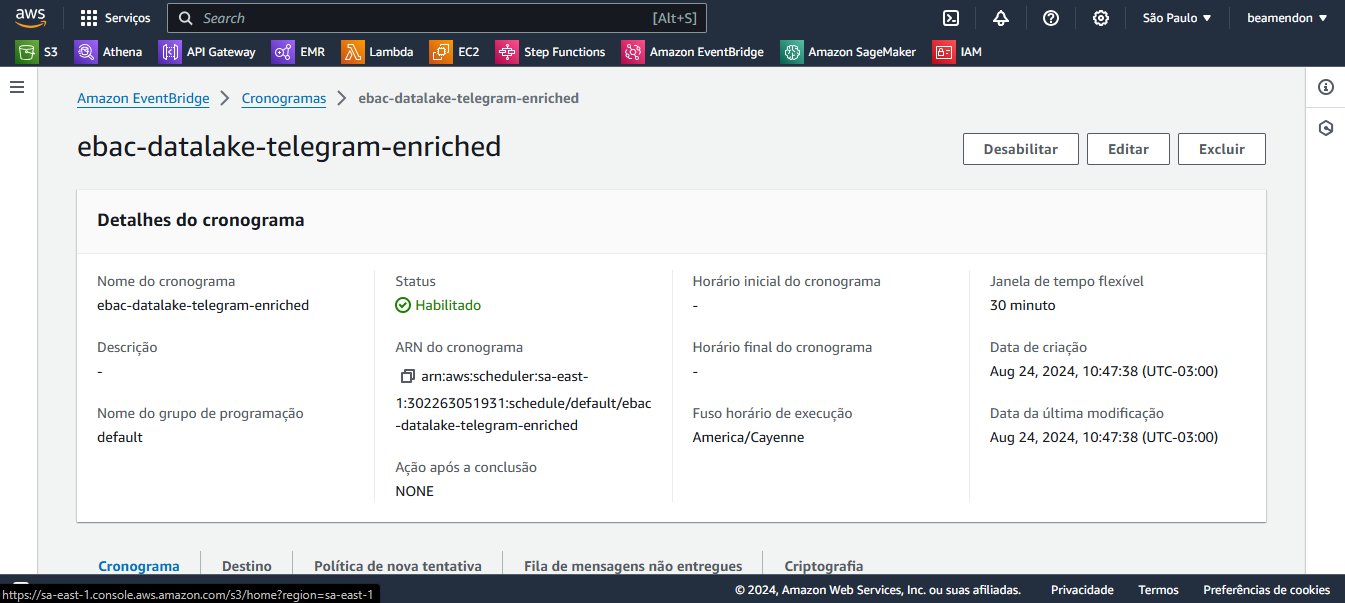

##**Data Analysis**

*Using AWS Athena*
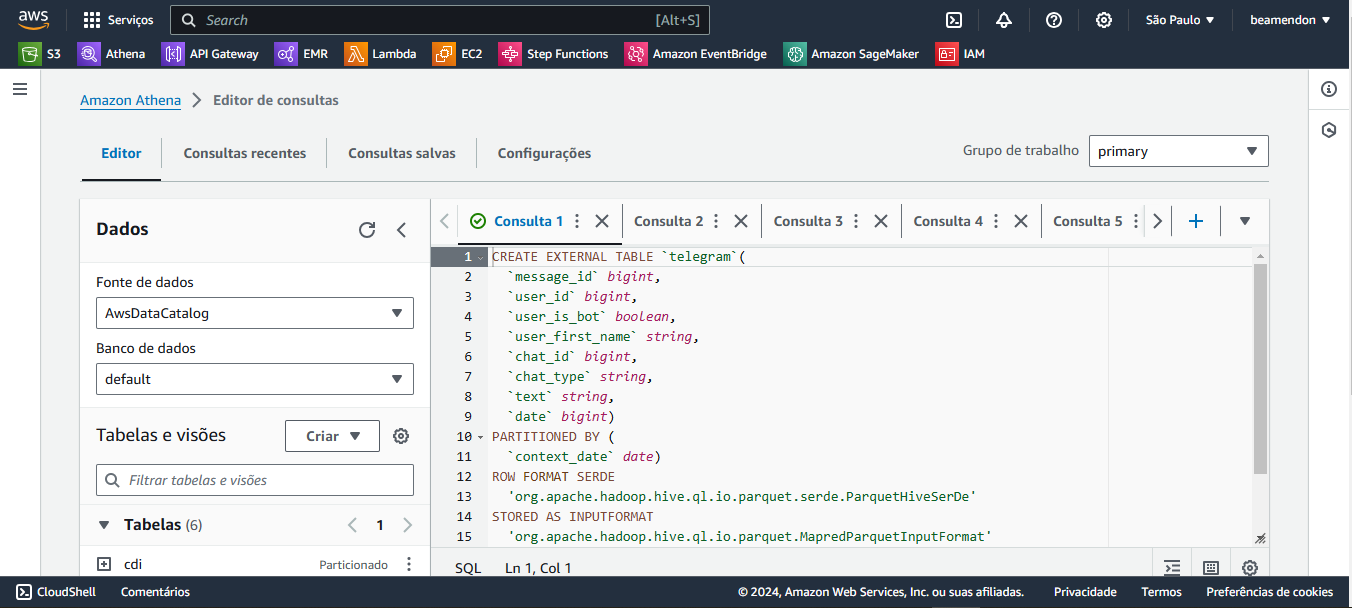

1. Table

```sql
SELECT * FROM "telegram" ORDER BY message_id;
```

2. Quantity of messages per day

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

3. Quantity of messages per day per user

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

4. Average message size per user per day

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

5. Number of messages per hour, per day of the week, by week number

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday

```